In [1]:
from keras import backend as K
from keras.layers import Input, Dense, Conv2D, MaxPooling2D
from keras.layers.core import Activation, Lambda, Dropout 
from keras.layers.core import Flatten
from keras.layers.recurrent import LSTM
from keras.layers import merge,Concatenate
from keras.layers.merge import concatenate
from keras.models import Model
from keras.utils.vis_utils import plot_model
import tensorflow as tf
from keras.engine.topology import Layer,InputSpec
import numpy as np




/home/rjpg/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import tensorflow as tf

class CylindricalPad(Layer):

    def __init__(self, n=1, **kwargs):
        super(CylindricalPad, self).__init__(**kwargs)
        self.n = n
        assert n > 0, 'n must be positive'
        
    def build(self, input_shape):
        self.input_spec = [InputSpec(shape=input_shape)]
        super(CylindricalPad, self).build(input_shape)  
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0],
                    input_shape[1],
                    input_shape[2],
                    input_shape[3] + 2*self.n)
            
    def call(self, elementA, mask=None):
        
        x_unpacked = tf.unstack(elementA)
        batchResultFlat=[]
        for batchElement in x_unpacked:
            resultFlat=[]
            batchElementUnpack = tf.unstack(batchElement)
            for cnnFilterImage in batchElementUnpack:
                
                ind = tf.constant(list(range(self.n)))
                firstColumns = tf.transpose(tf.nn.embedding_lookup(tf.transpose(cnnFilterImage), ind))
                
                result = tf.concat([cnnFilterImage,firstColumns], axis=1)
                
                ind = tf.constant(list(range(cnnFilterImage.shape[1]-self.n,cnnFilterImage.shape[1])))
                lastColumns = tf.transpose(tf.nn.embedding_lookup(tf.transpose(cnnFilterImage), ind))
                
                result = tf.concat([lastColumns,result], axis=1)
                
                #firstColumns=cnnFilterImage[:,list(range(self.n))]
                #newElement=tf.pad(cnnFilterImage, paddings, "REFLECT") 
                resultFlat.append(result)
                
                #print(cnnFilterImage)
            batchResultFlat.append(tf.stack(resultFlat))
        ret = tf.stack(batchResultFlat)
        
        return ret

    def get_config(self):
        config = {'cropping': self.cropping}
        base_config = super(Cropping2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

print("CylindricalPad")

CylindricalPad


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 1, 7, 5)           0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 20, 7, 5)          220       
_________________________________________________________________
lambda_10 (Lambda)           (None, 20, 7, 9)          0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 5, 7, 5)           505       
_________________________________________________________________
flatten_4 (Flatten)          (None, 175)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 880       
_________________________________________________________________
activation_4 (Activation)    (None, 5)                 0         
Total para

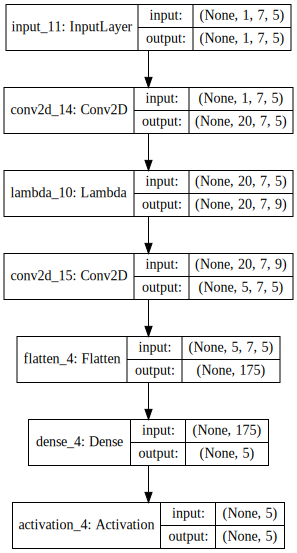

In [13]:

K.set_image_dim_ordering("th")


def transform3(testElement, n=2):
    firstColumns=testElement[:,:,:,0:n]
    lastColumns=testElement[:,:,:,testElement.shape[3]-n:testElement.shape[3]]
    result=tf.concat([testElement,firstColumns], axis=3)
    result=tf.concat([lastColumns,result], axis=3)
    return result

def transform(element,n):
    batchResultFlat=[]
    for batchElement in element:
        resultFlat=[]
        for cnnFilterImage in batchElement:
            print(cnnFilterImage)
            firstColumns=cnnFilterImage[:,list(range(n))]
            print( np.array(firstColumns))
            result=np.concatenate((cnnFilterImage,np.array(firstColumns)),axis=1)
            print(result)
            print(np.flipud(list(range(cnnFilterImage.shape[1]-n,cnnFilterImage.shape[1]))))
            #lastColumnsReverse=cnnFilterImage[:,np.flipud(list(range(cnnFilterImage.shape[1]-n,cnnFilterImage.shape[1])))]
            lastColumnsReverse=cnnFilterImage[:,list(range(cnnFilterImage.shape[1]-n,cnnFilterImage.shape[1]))]
            print(lastColumnsReverse)
            result=np.concatenate((np.array(lastColumnsReverse),result),axis=1)
            print(result)
            resultFlat.append(result)
        batchResultFlat.append(np.array(resultFlat))
    print(np.array(batchResultFlat))
    newElement = np.array(batchResultFlat)
    return newElement

def transformTest(element,n):
    if element.ndims > 0:
        return tf.map_fn(transformTest, inputs)
    else:
        return transform(inputs,n)
    return element

class RJPGNet:
    @staticmethod
    def build(timeSteps,variables,classes):
        #CONV=>POOL
        inputNet = Input(shape=(1,timeSteps,variables))#,batch_shape=(10,1, 7, 5)) 
        conv1=Conv2D(20, (2,5), padding="same")(inputNet)
        
        #######################################################################
        #conv1=CylindricalPad(n=2)(conv1)
        ################################# OR ##################################
        conv1=Lambda(lambda element : transform3(element,2))(conv1)
        #######################################################################
        
        conv2=Conv2D(5,(1,5), padding="valid")(conv1)
        
        flatten=Flatten()(conv2)
                
        classificationLayer=Dense(classes)(flatten)
        classificationLayer=Activation("softmax")(classificationLayer)
        
        model=Model(inputNet,classificationLayer)
        return model
    

    
modeltest=RJPGNet.build(timeSteps=7,variables=5,classes=5)
modeltest.compile(optimizer="adadelta", loss="categorical_crossentropy",metrics=["accuracy"])
modeltest.summary() 

#plot_model(modeltest, to_file="model.png",show_shapes=True)

#plot_model(modeltest, to_file="model.png",show_shapes=True)
from IPython.display import SVG,display
from keras.utils.vis_utils import model_to_dot
modelSVG=SVG(model_to_dot(modeltest,show_shapes=True).create(prog='dot', format='svg'))
display(modelSVG)


In [100]:
t = tf.constant([[1, 2, 3], [4, 5, 6]])
paddings = tf.constant([[0, 0], [2, 2]])
# 'constant_values' is 0.
# rank of 't' is 2.
tf.pad(t, paddings, "CONSTANT")  # [[0, 0, 0, 0, 0, 0, 0],
                                 #  [0, 0, 1, 2, 3, 0, 0],
                                 #  [0, 0, 4, 5, 6, 0, 0],
                                 #  [0, 0, 0, 0, 0, 0, 0]]

x=tf.pad(t, paddings, "REFLECT")  # [[6, 5, 4, 5, 6, 5, 4],
                                #  [3, 2, 1, 2, 3, 2, 1],
                                #  [6, 5, 4, 5, 6, 5, 4],
                                #  [3, 2, 1, 2, 3, 2, 1]]

tf.pad(t, paddings, "SYMMETRIC")  # [[2, 1, 1, 2, 3, 3, 2],
                                  #  [2, 1, 1, 2, 3, 3, 2],
                                  #  [5, 4, 4, 5, 6, 6, 5],
                                  #  [5, 4, 4, 5, 6, 6, 5]]
#tf.print(x,[x])
sess = tf.InteractiveSession()
c = sess.run(x)
print(c)
sess.close()

[[3 2 1 2 3 2 1]
 [6 5 4 5 6 5 4]]


/home/rjpg/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py:1714: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
